In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 

import xgboost
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

from collections import defaultdict

import optuna

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report


c:\Users\jcmar\my_files\SportsBetting\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# odds_df = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\upcoming_odds.csv')
# stats_df = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\new_combined.csv')
# upcoming_file_path = r'C:\Users\jcmar\my_files\SportsBetting\data\next_event_features.csv'
# upcoming_df = pd.read_csv(upcoming_file_path)

entire_odds_stats_path = r'C:\Users\jcmar\my_files\SportsBetting\data\entire_odds_stats.csv'

full_df = pd.read_csv(entire_odds_stats_path)
print(full_df.shape)

(6796, 130)


In [ ]:
with pd.option_context('display.max_info_columns', 1000):

    full_df.info()

In [2]:
df_v2 = pd.read_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\entire_odds_stats_v2.csv')


In [4]:
with pd.option_context('display.max_info_columns', 1000):

    df_v2[model_cols_v2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7954 entries, 0 to 7953
Data columns (total 146 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    date                         7954 non-null   object 
 1    winner                       7954 non-null   int64  
 2    red_fighter                  7954 non-null   object 
 3    blue_fighter                 7954 non-null   object 
 4    reach_blue                   7354 non-null   float64
 5    reach_red                    7778 non-null   float64
 6    reach_diff                   7223 non-null   float64
 7    age_diff                     7911 non-null   float64
 8    blue_age                     7915 non-null   float64
 9    red_age                      7949 non-null   float64
 10   height_blue                  7952 non-null   float64
 11   height_red                   7953 non-null   float64
 12   weight_class                 7954 non-null   object 
 13   t

In [5]:
final_df = df_v2[df_v2['winner'] != 2]

xgb_dat = final_df[model_cols_v2].dropna()
copy_df = xgb_dat.copy()
print('AFTER NA SHAPE: ', xgb_dat.shape)

le = LabelEncoder()
# xgb_dat['event_country'] = le.fit_transform(xgb_dat['event_country'])
xgb_dat['weight_class'] = le.fit_transform(xgb_dat['weight_class'])

mm_scaler = MinMaxScaler()
cat_cols = xgb_dat.select_dtypes(include=['object', 'category']).columns.tolist()
num_categorical = xgb_dat.select_dtypes(include=['object']).shape[1]
print(f"Number of categorical columns: {num_categorical}")
numerical_cols = xgb_dat.columns.difference(cat_cols)
xgb_dat[numerical_cols] = mm_scaler.fit_transform(xgb_dat[numerical_cols])

train_len = int(xgb_dat.shape[0] * .85)

train_dat = xgb_dat.iloc[:train_len]
test_dat = xgb_dat.iloc[train_len:]

X_train = train_dat.drop(columns=['winner','red_fighter','blue_fighter','date'])
y_train = train_dat['winner']

X_test = test_dat.drop(columns=['winner','red_fighter','blue_fighter','date'])
y_test= test_dat['winner']

AFTER NA SHAPE:  (5651, 146)
Number of categorical columns: 3


C:\Users\jcmar\AppData\Local\Temp\ipykernel_42176\3931204927.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


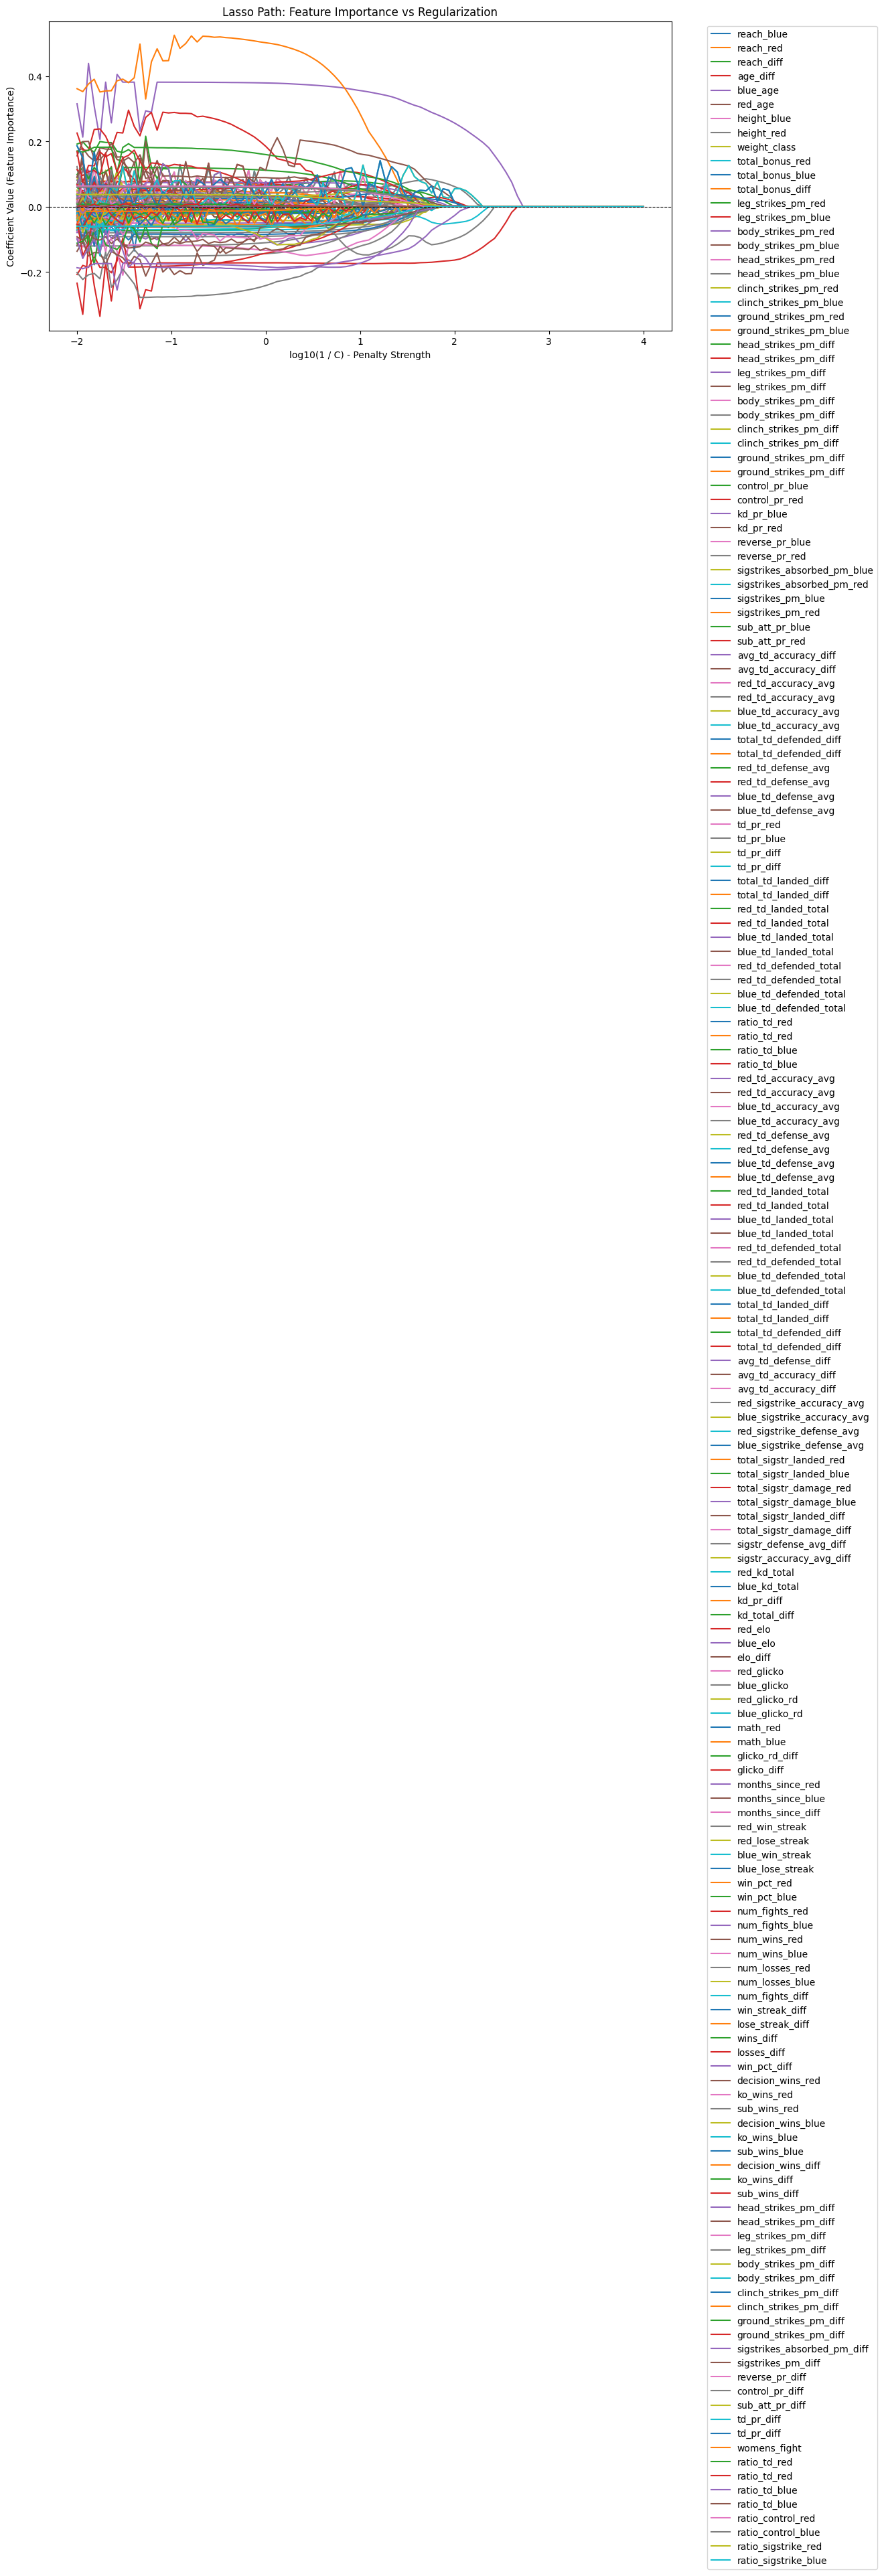

In [6]:
# Range of regularization strengths
C_values = np.logspace(2, -4, 100)  # From 100 to 0.0001

# Track coefficients
coefs = []

for C in C_values:
    model = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    )
    model.fit(X_train, y_train)
    coef = model.named_steps['logisticregression'].coef_[0]
    coefs.append(coef)

# Convert to array and DataFrame
coefs = np.array(coefs)
coef_df = pd.DataFrame(coefs, columns=X_train.columns)

# Plot
plt.figure(figsize=(12, 6))
for feature in coef_df.columns:
    plt.plot(np.log10(1 / C_values), coef_df[feature], label=feature)

plt.xlabel('log10(1 / C) - Penalty Strength')
plt.ylabel('Coefficient Value (Feature Importance)')
plt.title('Lasso Path: Feature Importance vs Regularization')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
coef_df.head()
ranks = {}

for feature in coef_df.columns:
    coefs = coef_df[feature].values
    # Find first index where coefficient is zero and stays zero afterwards
    zero_indices = np.where(coefs == 0)[0]
    if len(zero_indices) == 0:
        # Never zero, highest importance → set vanish_index after max index
        vanish_index = len(C_values)
    else:
        # Check for the first index after which all remain zero
        vanish_index = None
        for idx in zero_indices:
            if np.all(coefs[idx:] == 0):
                vanish_index = idx
                break
        if vanish_index is None:
            # If no stable zero, treat as never vanished
            vanish_index = len(C_values)

    ranks[feature] = vanish_index

# Convert to DataFrame and sort by vanish_index ascending (vanish earlier = less important)
rank_df = pd.DataFrame.from_dict(ranks, orient='index', columns=['vanish_index'])
rank_df['rank'] = rank_df['vanish_index'].rank(method='min', ascending=False).astype(int)
rank_df = rank_df.sort_values('rank')

pd.set_option('display.max_rows', None)
print(rank_df[['rank', 'vanish_index']])
pd.reset_option('display.max_rows')

                             rank  vanish_index
blue_age                        1            78
age_diff                        2            77
num_losses_red                  3            74
sigstrikes_absorbed_pm_red      4            72
sigstr_defense_avg_diff         5            71
td_pr_diff                      5            71
control_pr_red                  7            69
sigstrikes_absorbed_pm_diff     7            69
win_streak_diff                 9            68
head_strikes_pm_diff            9            68
sigstrikes_pm_diff             11            67
reach_diff                     12            66
avg_td_defense_diff            12            66
blue_td_defense_avg            14            65
elo_diff                       14            65
sub_att_pr_blue                16            64
red_sigstrike_accuracy_avg     16            64
ratio_sigstrike_red            16            64
blue_td_defended_total         16            64
win_pct_blue                   20       

Confusion matrix:
 [[229 140]
 [185 294]]

Accuracy: 0.6167

Classification report:
               precision    recall  f1-score   support

         0.0       0.55      0.62      0.58       369
         1.0       0.68      0.61      0.64       479

    accuracy                           0.62       848
   macro avg       0.62      0.62      0.61       848
weighted avg       0.62      0.62      0.62       848



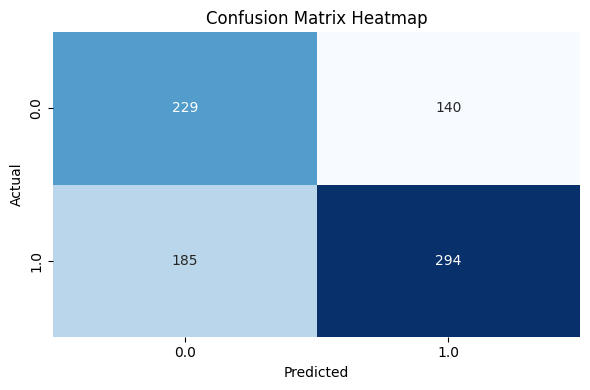

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predict
y_pred = model.predict(X_test)

# probs 
probs_2d = model.predict_proba(X_test)

# 5. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# 6. Accuracy & report
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

# 7. Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

In [60]:
test_answers = pd.DataFrame()


test_answers['blue_probs'] = probs_2d[:,0]
test_answers['red_probs'] = probs_2d[:,1]
test_answers['pred_winner'] = np.argmax(probs_2d, axis=1)

test_answers['winner'] = copy_df.iloc[train_len:]['winner'].reset_index(drop=True)
# test_answers['winner'] = y_test.reset_index(drop=True)
test_answers['correct_pred'] = (test_answers['pred_winner'] == test_answers['winner']).astype(int)
test_answers['event_dates'] = copy_df.iloc[train_len:]['date'].reset_index(drop=True)

test_answers['open_red'] = copy_df.iloc[train_len:]['open_red'].reset_index(drop=True)
test_answers['open_blue'] = copy_df.iloc[train_len:]['open_blue'].reset_index(drop=True)
test_answers['event_dates'] = copy_df.iloc[train_len:]['date'].reset_index(drop=True)
test_answers['red_fighter'] = copy_df.iloc[train_len:]['red_fighter'].reset_index(drop=True)
test_answers['blue_fighter'] = copy_df.iloc[train_len:]['blue_fighter'].reset_index(drop=True)

test_answers.info()
print(test_answers.info())

test_answers.to_csv(r'C:\Users\jcmar\my_files\SportsBetting\data\model_results_v2.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   blue_probs    751 non-null    float64
 1   red_probs     751 non-null    float64
 2   pred_winner   751 non-null    int64  
 3   winner        751 non-null    int64  
 4   correct_pred  751 non-null    int64  
 5   event_dates   751 non-null    object 
 6   open_red      751 non-null    float64
 7   open_blue     751 non-null    float64
 8   red_fighter   751 non-null    object 
 9   blue_fighter  751 non-null    object 
dtypes: float64(4), int64(3), object(3)
memory usage: 58.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   blue_probs    751 non-null    float64
 1   red_probs     751 non-null    float64
 2   pred_winner   751 non-null    int6